In [112]:
# Generate Deflections of a cantilever beam analytically
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 2.0             # Length of the beam [m]
EI = 2e6            # Flexural rigidity [Nm^2]
q_true_val = 1000.0 # Uniform load [N/m]

# Position array
x_full = np.linspace(0, L, 200)
x_full_norm = x_full/ L
# Analytical deflection
def w(x):
 w = (q_true_val * x**2 * (6*L**2 - 4*L*x + x**2)) / (24 * EI)
 return w



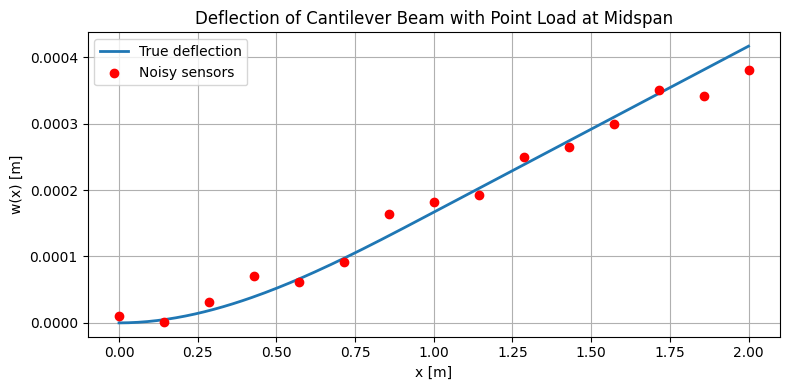

In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Beam parameters
L = 2.0              # Length [m]
EI = 2e6             # Flexural rigidity [Nm²]
P = 1000.0           # Point load [N]
a = L / 2            # Load applied at midspan

# Define deflection function for point load
def w_point_load(x):
    w = np.zeros_like(x)
    mask1 = x <= a
    mask2 = x > a
    w[mask1] = (P * x[mask1]**2 * (3*a - x[mask1])) / (6 * EI)
    w[mask2] = (P * a**2 * (3*x[mask2] - a)) / (6 * EI)
    return w

# Generate data
x_full = np.linspace(0, L, 200)
w_true = w_point_load(x_full)

# Sample sensor locations and add noise
x_sensors = np.linspace(0, L, 15)
w_sensors_clean = w_point_load(x_sensors)

np.random.seed(42)
noise_std = 0.05 * np.max(w_sensors_clean)
noise = np.random.normal(0, noise_std, size=w_sensors_clean.shape)
w_sensors_noisy = w_sensors_clean + noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_full, w_true, label="True deflection", linewidth=2)
plt.scatter(x_sensors, w_sensors_noisy, color='red', label="Noisy sensors", zorder=3)
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.title("Deflection of Cantilever Beam with Point Load at Midspan")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [114]:
# Sampling for some Sensors readings
x_sensors = np.linspace(0, L, 15)
w_sensors_clean = w(x_sensors)

mean_bias = 0.05 * np.max(w_sensors_clean)   # e.g., 5% upward bias
noise_std = 0.1 * np.max(w_sensors_clean)   # 10% random variation
noise = np.random.normal(loc=mean_bias, scale=noise_std, size=w_sensors_clean.shape)

w_sensors_noisy = w_sensors_clean + noise  # add noise to clean deflections

# Normalisation
x_sensors_norm = (x_sensors / L).reshape(-1, 1)
w_max = w_sensors_clean.max()  # still use clean max for scaling
w_sensors_norm = (w_sensors_noisy / w_max).reshape(-1, 1)


In [115]:
#Data prep for NN
import tensorflow as tf
x_tf = tf.convert_to_tensor(x_full_norm, dtype=tf.float32)
x_sensors_tf = tf.convert_to_tensor(x_sensors_norm, dtype=tf.float32)
w_sensors_tf = tf.convert_to_tensor(w_sensors_norm.reshape(-1, 1), dtype=tf.float32)

#a = tf.Variable(0, dtype=tf.float32)
#b = tf.Variable(0, dtype=tf.float32)
c = tf.Variable(1.0, dtype=tf.float32)

In [116]:
#Create NN model
import tensorflow as tf
from tensorflow.keras import layers, models
def create_model():
    return models.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(20, activation='swish'),
        layers.Dense(20, activation='swish'),
        layers.Dense(1)
    ])

model_w = create_model()
optimizer_w = tf.keras.optimizers.Adam(1e-3)
optimizer_q = tf.keras.optimizers.Adam(0.002)

def compute_derivatives(x_input):
    with tf.GradientTape(persistent=True) as tape4:
        tape4.watch(x_input)
        with tf.GradientTape(persistent=True) as tape3:
            tape3.watch(x_input)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x_input)
                with tf.GradientTape() as tape1:
                    tape1.watch(x_input)
                    w_hat = model_w(x_input)
                dw = tape1.gradient(w_hat, x_input)
            d2w = tape2.gradient(dw, x_input)
        d3w = tape3.gradient(d2w, x_input)
    d4w = tape4.gradient(d3w, x_input)
    return w_hat, dw, d2w, d3w, d4w

In [117]:
beta = tf.constant(0.9, dtype=tf.float32)

w_data = tf.Variable(0.2, dtype=tf.float32, trainable=False)
w_phys = tf.Variable(0.6, dtype=tf.float32, trainable=False)
w_bc = tf.Variable(0.1, dtype=tf.float32, trainable=False)
w_fe = tf.Variable(0.1, dtype=tf.float32, trainable=False)
w_all_conditions = tf.Variable(1.0, dtype=tf.float32, trainable=False)

In [ ]:
@tf.function
def train_step(epoch):
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:

            w_hat, dw, d2w, d3w, d4w = compute_derivatives(x_sensors_tf)
            q_hat = tf.ones_like(d4w) * c
            f_pred = d4w
            physics_loss = tf.reduce_mean(tf.square((f_pred - q_hat)))
            #tf.print("physics_loss:", physics_loss)

            w_sensor_pred = model_w(x_sensors_tf)
            data_loss = tf.reduce_mean(tf.square(w_sensor_pred - w_sensors_tf))
            w0, dw0, *_ = compute_derivatives(tf.convert_to_tensor([[0.0]], dtype=tf.float32))
            bc_loss = tf.square(w0) + tf.square(dw0)
            wL, dwL, d2wL, d3wL, *_ = compute_derivatives(tf.convert_to_tensor([[1.0]], dtype=tf.float32))
            free_end_loss = tf.square(d2wL) + tf.square(d3wL)

    ''' if epoch % 10 == 0:
            vars = model_w.trainable_variables
            vars_weights = [var for var in vars if ('kernel' in var.name) or ('weight:' in var.name)]

            grad_res = tape1.gradient(physics_loss, vars_weights)
            grad_data = tape1.gradient(data_loss, vars_weights)
            grad_bcs = tape1.gradient(bc_loss, vars_weights)
            grad_free_end = tape1.gradient(free_end_loss, vars_weights)

            grad_res_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_res], axis=0)
            grad_data_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_data], axis=0)
            grad_bcs_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_bcs], axis=0)
            grad_free_end_flatten = tf.concat([tf.reshape(g, [-1]) for g in grad_free_end], axis=0)
            grad_all_conditions_flatten = grad_data_flatten + grad_bcs_flatten #+ grad_free_end_flatten

            max_grad_res = tf.reduce_max(abs(grad_res_flatten))
            mean_grad_data = tf.reduce_mean(abs(grad_data_flatten))
            mean_grad_bcs = tf.reduce_mean(abs(grad_bcs_flatten))
            mean_grad_free_end = tf.reduce_mean(abs(grad_free_end_flatten))
            mean_grad_all_conditions = tf.reduce_mean(abs(grad_all_conditions_flatten))

            w_data_hat = max_grad_res / mean_grad_data
            w_bc_hat = max_grad_res / mean_grad_bcs
            w_fe_hat = max_grad_res / mean_grad_free_end
            w_all_conditions_hat = max_grad_res / mean_grad_all_conditions
            w_all_conditions_hat = tf.clip_by_value(w_all_conditions_hat, 0.0, 1000.0)

            tf.print("max_grad:", max_grad)
            tf.print("mean_grad_data:", mean_grad_data)
            tf.print("mean_grad_bcs:", mean_grad_bcs)
            tf.print("mean_grad_free_end:", mean_grad_free_end)

            tf.print("w_data_hat:", w_data_hat)
            tf.print("w_bc_hat:", w_bc_hat)
            tf.print("w_fe_hat:", w_fe_hat)

            w_data.assign(w_data * beta + w_data_hat * (1 - beta))
            w_bc.assign(w_bc * beta + w_bc_hat * (1 - beta))
            w_fe.assign(w_fe * beta + w_fe_hat * (1 - beta))
            w_all_conditions.assign(w_all_conditions * beta + w_all_conditions_hat * (1 - beta))'''

        physics_loss = w_phys * physics_loss
        data_loss = w_data * data_loss
        bc_loss = w_bc * bc_loss
        free_end_loss = w_fe  * free_end_loss

        total_loss = physics_loss + data_loss + bc_loss + free_end_loss

    grads_w = tape2.gradient(total_loss, model_w.trainable_variables)
    grads_params = tape2.gradient(total_loss, [ c])
    optimizer_w.apply_gradients(zip(grads_w, model_w.trainable_variables))
    optimizer_q.apply_gradients(zip(grads_params, [c]))

    return total_loss, data_loss, physics_loss, bc_loss, free_end_loss, w_data, w_bc, w_fe, w_all_conditions

In [119]:
history = {"loss": [], "data": [], "phys": [], "bc": [], "free_end": []}
for epoch in range(25000):
    loss, data_l, phys_l, bc_l , free_l, w_data, w_bc, w_fe, w_all_conditions = train_step(tf.cast(epoch, tf.float32))
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss.numpy().item():.6f} | "f"Data: {data_l.numpy().item():.6f} | Phys: {phys_l.numpy().item():.6f} | BC: {bc_l.numpy().item():.6f}| FreeEnd: {free_l.numpy().item():.6f} |w data:{w_data.numpy()} |w bc{w_bc.numpy()} w fe {w_fe.numpy()}")
    history["loss"].append(loss.numpy().item())
    history["data"].append(data_l.numpy().item())
    history["phys"].append(phys_l.numpy().item())
    history["bc"].append(bc_l.numpy().item())
    history["free_end"].append(free_l.numpy().item())

Epoch     0 | Total: 0.729564 | Data: 0.086628 | Phys: 0.639396 | BC: 0.002945| FreeEnd: 0.000596 |w data:0.20000000298023224 |w bc0.10000000149011612 w fe 0.10000000149011612
Epoch   500 | Total: 0.021293 | Data: 0.012007 | Phys: 0.000810 | BC: 0.007535| FreeEnd: 0.000940 |w data:0.20000000298023224 |w bc0.10000000149011612 w fe 0.10000000149011612
Epoch  1000 | Total: 0.020420 | Data: 0.011646 | Phys: 0.000063 | BC: 0.007362| FreeEnd: 0.001349 |w data:0.20000000298023224 |w bc0.10000000149011612 w fe 0.10000000149011612
Epoch  1500 | Total: 0.020288 | Data: 0.011583 | Phys: 0.000044 | BC: 0.007306| FreeEnd: 0.001356 |w data:0.20000000298023224 |w bc0.10000000149011612 w fe 0.10000000149011612
Epoch  2000 | Total: 0.020124 | Data: 0.011498 | Phys: 0.000035 | BC: 0.007236| FreeEnd: 0.001354 |w data:0.20000000298023224 |w bc0.10000000149011612 w fe 0.10000000149011612
Epoch  2500 | Total: 0.019916 | Data: 0.011386 | Phys: 0.000033 | BC: 0.007150| FreeEnd: 0.001347 |w data:0.200000002980

In [128]:
# Final predictions
w_hat, dw, d2w, d3w, d4w = compute_derivatives(x_tf)
w_pred = w_hat.numpy() * w_max
#w_pred = scaler_w.inverse_transform(w_hat.numpy()).flatten()
#sigma_w = scaler_w.scale_[0]
#a_dim = a.numpy() * EI * w_max/ L**6
#b_dim = b.numpy() * EI * w_max/ L**5
c_dim = c.numpy() * EI * w_max/ L**4

# Step 2: Reconstruct q(x) in physical units
q_pred = c_dim.flatten()

R² score (PINN Model): 0.99933


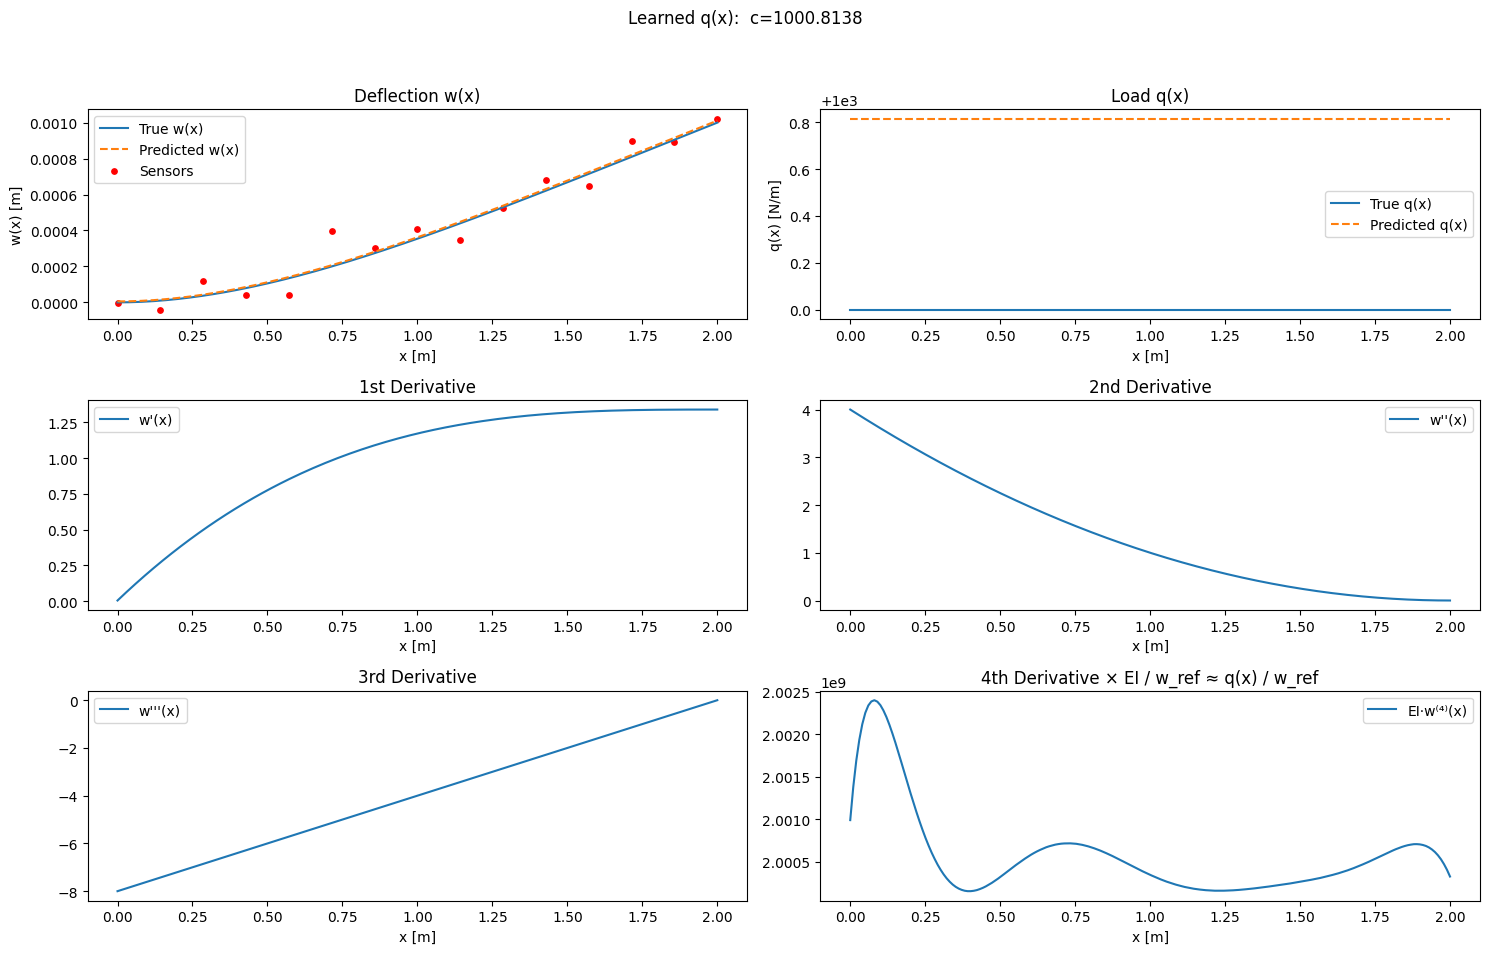

In [130]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2)

# Define plotting x and evaluate true values
x_plot = x_full  # Dimensional x values
w_true = w(x_plot)  # True analytical deflection
q_true = q_true_val * np.ones_like(x_plot)  # Constant uniform load

plt.subplot(gs[0, 0])
plt.plot(x_plot, w_true, label="True w(x)")
plt.plot(x_plot, w_pred, '--', label="Predicted w(x)")
plt.scatter(x_sensors, w_sensors_noisy, color='red', label="Sensors", s=15)
plt.title("Deflection w(x)")
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()

plt.subplot(gs[0, 1])
plt.plot(x_plot, q_true, label="True q(x)")
plt.plot(x_plot, np.full_like(x_plot, q_pred), '--', label="Predicted q(x)")
plt.title("Load q(x)")
plt.xlabel("x [m]")
plt.ylabel("q(x) [N/m]")
plt.legend()

plt.subplot(gs[1, 0])
plt.plot(x_plot, dw.numpy(), label="w'(x)")
plt.title("1st Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[1, 1])
plt.plot(x_plot, d2w.numpy(), label="w''(x)")
plt.title("2nd Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[2, 0])
plt.plot(x_plot, d3w.numpy(), label="w'''(x)")
plt.title("3rd Derivative")
plt.xlabel("x [m]")
plt.legend()

# Ensure w_ref is defined for correct scaling
w_ref = q_true_val * L**4 / EI

plt.subplot(gs[2, 1])
plt.plot(x_plot, d4w.numpy() * EI / w_ref, label="EI·w⁽⁴⁾(x)")
#plt.plot(x_plot, q_pred , '--', label="Predicted q(x) / w_ref")
plt.title("4th Derivative × EI / w_ref ≈ q(x) / w_ref")
plt.xlabel("x [m]")
plt.legend()
plt.suptitle(f"Learned q(x):  c={c_dim:.4f}")

from sklearn.metrics import r2_score
r2_data = r2_score(w_true, w_pred)
print(f"R² score (PINN Model): {r2_data:.5f}")
#plt.suptitle(f"Learned q(x): a={a_dim:.4f}, b={b_dim:.4f}, c={c_dim:.4f}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# Compute R²




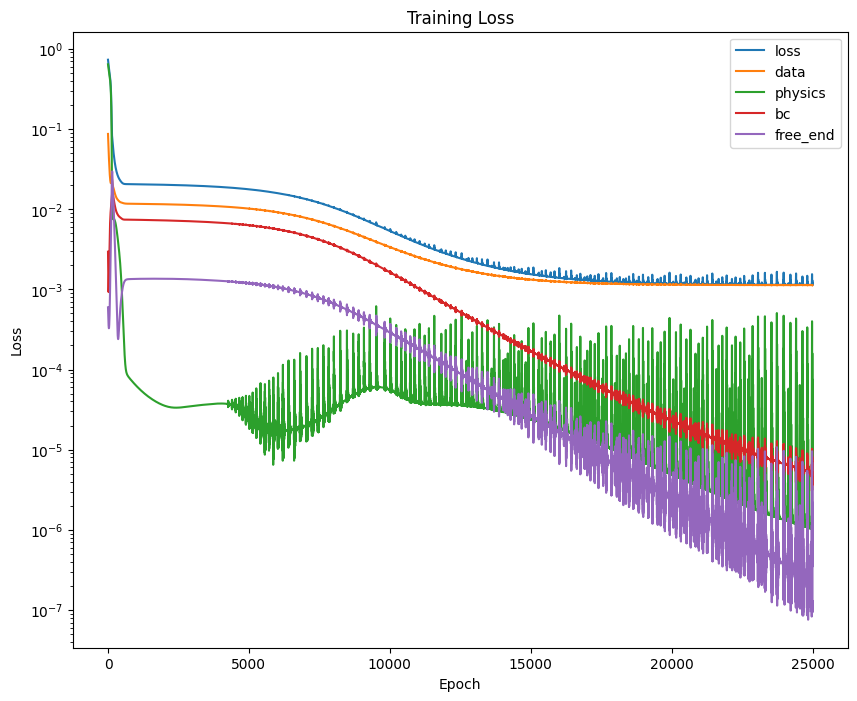

In [122]:
plt.figure(figsize=(10, 8))
plt.plot(history['loss'])
plt.plot(history['data'])
plt.plot(history['phys'])
plt.plot(history['bc'])
plt.plot(history['free_end'])
plt.legend(['loss', 'data', 'physics', 'bc', 'free_end'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
